# Hail Conv Net Filter Activations

This notebook contains the examples that activate each convolutional filter in the last layer of a hail neural net.

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import keras.backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.neighbors import KernelDensity
import xarray as xr
from deepsky.data import load_storm_patch_data
from deepsky.gan import normalize_multivariate_data, unnormalize_multivariate_data
from scipy.ndimage import gaussian_filter
from hagelslag.evaluation.ContingencyTable import ContingencyTable
import yaml
from os.path import join, exists
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
config_file = "/glade/u/home/dgagne/deepsky/config/spatial_storm_model_config.yaml"
with open(config_file) as config_obj:
    config = yaml.load(config_obj)

Load storm data from netCDF and normalize it.

In [3]:
sess = K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=False,
                                                       gpu_options=K.tf.GPUOptions(allow_growth=True),
                                                       log_device_placement=False))
K.set_session(sess)

In [4]:
data_path = "/glade/work/dgagne/ncar_ens_storm_patches/"
input_variables = config["input_variables"]
num_proc = 4
print("Loading data")
storm_data, storm_meta = load_storm_patch_data(data_path, input_variables, num_proc)
storm_norm_data, storm_scaling_values = normalize_multivariate_data(storm_data)

Loading data
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 9

In [5]:
output_config = config["output"]
output_data, output_meta = load_storm_patch_data(data_path,
                                                     [output_config["variable"],
                                                      output_config["mask"]], 4)
max_hail = np.array([output_data[i, :, :, 0][output_data[i, :, :, 1] > 0].max()
                         for i in range(output_data.shape[0])])
max_hail *= 1000
hail_labels = np.where(max_hail >= output_config["threshold"], 1, 0)

/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc 325
/glade/wor

In [6]:
model_path = "/glade/work/dgagne/spatial_storm_results_20171220/"
sample = 3
hail_cnn = load_model(join(model_path, "hail_conv_net_sample_{0:03d}.h5".format(sample)))
#log_pca = pickle.load(open(join(model_path, "hail_logistic_pca_sample_003.pkl"), 'rb'))

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [7]:
hail_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12032     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

## Activated Analogs
Calculate which examples activate which neural network neurons.

In [8]:
def activated_analogs(norm_data, hail_labels, cnn_model, num_analogs=16, filter_index=(0, 0), dense_layer_index=-2,
                      conv_layer_index=-6, batch_size=4096):
    """
    For a given convolutional neural network, identify the examples that most activate a given set of
    neurons in a convolutional layer.

    Args:
        norm_data: Normalized input data for the convolutional neural network
        cnn_model: Keras convolutional neural network model object
        num_analogs: Number of activated input examples to store for each neuron
        filter_index: Spatial array index of convolution filters being evaluated
        dense_layer_index: Index of the final dense layer that connects the convolutions and outputs
        conv_layer_index: Index of the activation of the final convolutional layer.

    Returns:
        dense_weights (array of weight values), top_analog_ids (input data indices associated with each neuron),
        top_analog_activations (the magnitude of the activation), top_analog_gradients (gradients with respect
        to the input for each of the top analogs)
    """
    dense_weights = pd.Series(cnn_model.layers[dense_layer_index].get_weights()[0].reshape(
        cnn_model.layers[conv_layer_index].output_shape[1:])[filter_index], name="Weights")
    top_analog_ids = pd.DataFrame(np.zeros((dense_weights.shape[-1], num_analogs), dtype=int),
                                  columns=["Analog_ID_{0:02d}".format(a) for a in range(num_analogs)])
    top_analog_activations = pd.DataFrame(np.zeros((dense_weights.shape[-1], num_analogs)),
                                          columns=["Analog_Act_{0:02d}".format(a) for a in range(num_analogs)])
    top_analog_gradients = np.zeros([dense_weights.shape[-1], num_analogs] + list(norm_data.shape[1:]))
    analog_rocs = pd.DataFrame(np.zeros((dense_weights.shape[-1], 2)), columns=["Positive_AUC", "Negative_AUC"])
    for w in range(dense_weights.shape[-1]):
        filter_out = cnn_model.layers[conv_layer_index].output[:, filter_index[0], filter_index[1], w]
        act_func = K.function([cnn_model.input, K.learning_phase()],
                              [filter_out])
        loss = (filter_out - 5) ** 2
        grad = K.gradients(loss, cnn_model.input)[0]
        grad /= K.maximum(K.std(grad), K.epsilon())
        grad_func = K.function([cnn_model.input, K.learning_phase()], [grad])
        max_acts = np.zeros(norm_data.shape[0])
        for b in range(0, norm_data.shape[0], batch_size):
            batch_slice = slice(b,np.minimum(b + batch_size, norm_data.shape[0]) )
            max_acts[batch_slice] = act_func([norm_data[batch_slice], 0])[0]
        scaled_acts = (max_acts - max_acts.min()) / (max_acts.max() - max_acts.min())
        analog_rocs.loc[w, "Positive_AUC"] = roc_auc_score(hail_labels, scaled_acts)
        analog_rocs.loc[w, "Negative_AUC"] = roc_auc_score(hail_labels, 1-scaled_acts)
        top_analog_ids.loc[w] = np.argsort(max_acts)[::-1][:num_analogs]
        top_analog_activations.loc[w] = max_acts[top_analog_ids.loc[w]]
        top_analog_gradients[w] = grad_func([norm_data[top_analog_ids.loc[w]], 0])[0]
        print(w, dense_weights[w], analog_rocs.loc[w])
    combined_info = pd.concat([top_analog_ids, top_analog_activations, dense_weights, analog_rocs], axis=1)
    return combined_info, top_analog_gradients

In [16]:
analog_info, analog_gradients = activated_analogs(storm_norm_data, hail_labels, hail_cnn, filter_index=(2, 1))

0 0.00204888 Positive_AUC    0.291838
Negative_AUC    0.708162
Name: 0, dtype: float64
1 -0.012592905 Positive_AUC    0.250356
Negative_AUC    0.749644
Name: 1, dtype: float64
2 -0.020995142 Positive_AUC    0.270015
Negative_AUC    0.729985
Name: 2, dtype: float64
3 -0.01590965 Positive_AUC    0.534314
Negative_AUC    0.465686
Name: 3, dtype: float64
4 0.018809142 Positive_AUC    0.346335
Negative_AUC    0.653665
Name: 4, dtype: float64
5 0.014068643 Positive_AUC    0.497741
Negative_AUC    0.502259
Name: 5, dtype: float64
6 -0.028492698 Positive_AUC    0.187811
Negative_AUC    0.812189
Name: 6, dtype: float64
7 -0.012587841 Positive_AUC    0.610287
Negative_AUC    0.389713
Name: 7, dtype: float64
8 -0.023416743 Positive_AUC    0.322869
Negative_AUC    0.677131
Name: 8, dtype: float64
9 -0.007913616 Positive_AUC    0.360383
Negative_AUC    0.639617
Name: 9, dtype: float64
10 -0.015624958 Positive_AUC    0.314332
Negative_AUC    0.685668
Name: 10, dtype: float64
11 -0.00073953747 Positi

In [7]:
data_acts = np.zeros((storm_norm_data.shape[0], 3))
batch_size = 4096
for i, w in enumerate([48, 106, 93]):
    filter_out = hail_cnn.layers[-6].output[:, 2, 1, w]
    act_func = K.function([hail_cnn.input, K.learning_phase()],
                              [filter_out])
    for b in range(0, storm_norm_data.shape[0], batch_size):
        print(b)
        batch_slice = slice(b,np.minimum(b + batch_size, storm_norm_data.shape[0]) )
        data_acts[batch_slice, i] = act_func([storm_norm_data[batch_slice], 0])[0]

0
4096
8192
12288
16384
20480
24576
28672
32768
36864
40960
45056
49152
53248
57344
61440
65536
69632
73728
77824
81920
86016
90112
94208
98304
102400
106496
110592
0
4096
8192
12288
16384
20480
24576
28672
32768
36864
40960
45056
49152
53248
57344
61440
65536
69632
73728
77824
81920
86016
90112
94208
98304
102400
106496
110592
0
4096
8192
12288
16384
20480
24576
28672
32768
36864
40960
45056
49152
53248
57344
61440
65536
69632
73728
77824
81920
86016
90112
94208
98304
102400
106496
110592


Calculate the percentage of severe hailstorms for each neuron.

In [8]:
storm_mode_hail_percent = np.zeros(3)
for i in range(3):
    storm_high_acts = np.where(data_acts[:, i] >= 0.5)[0]
    storm_mode_hail_percent[i] = hail_labels[storm_high_acts].sum() / hail_labels[storm_high_acts].size
print(storm_mode_hail_percent)

[0.62169389 0.34217493 0.02049606]


/glade/u/apps/dav/opt/python/3.6.4/intel/17.0.1/pkg-library/20180801-DL/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


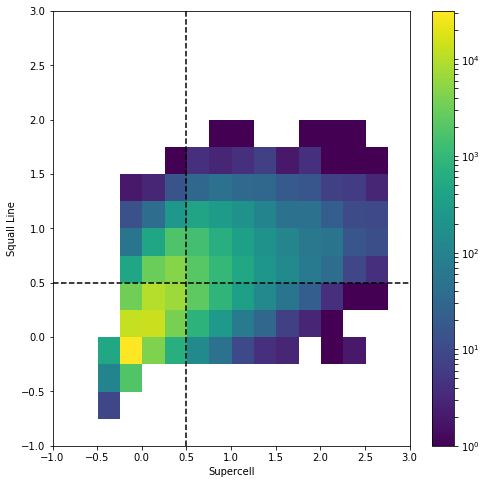

In [94]:
plt.figure(figsize=(8, 8))
plt.hist2d(data_acts[:, 0], data_acts[:, 1], cmin=1, bins=np.arange(-1, 3, 0.25), norm=LogNorm())
plt.xlabel("Supercell")
plt.ylabel("Squall Line")
plt.colorbar()
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.plot(np.ones(10) * 0.5, np.linspace(-1, 3, 10), 'k--')
plt.plot(np.linspace(-1, 3, 10), np.ones(10) * 0.5,  'k--')

In [9]:
thresholds = np.arange(-1, 3.1, 0.1)
ct = ContingencyTable(0, 0, 0, 0)
hsses = np.zeros((thresholds.size, 2))
for t, thresh in enumerate(thresholds):
    tp = np.count_nonzero((data_acts[:, 0] >= thresh) & (hail_labels==1))
    fp = np.count_nonzero((data_acts[:, 0] >= thresh) & (hail_labels==0))
    fn = np.count_nonzero((data_acts[:, 0] < thresh) & (hail_labels==1))
    tn = np.count_nonzero((data_acts[:, 0] < thresh) & (hail_labels==0))
    ct.update(tp, fp, fn, tn)
    hsses[t, 0] = ct.hss()
for t, thresh in enumerate(thresholds):
    tp = np.count_nonzero((data_acts[:, 1] >= thresh) & (hail_labels==1))
    fp = np.count_nonzero((data_acts[:, 1] >= thresh) & (hail_labels==0))
    fn = np.count_nonzero((data_acts[:, 1] < thresh) & (hail_labels==1))
    tn = np.count_nonzero((data_acts[:, 1] < thresh) & (hail_labels==0))
    ct.update(tp, fp, fn, tn)
    hsses[t, 1] = ct.hss()
    

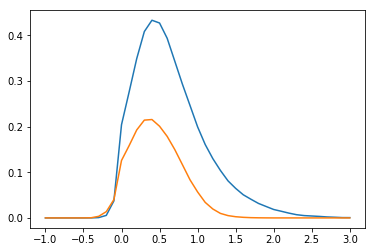

In [81]:
plt.plot(thresholds, hsses[:, 0])
plt.plot(thresholds, hsses[:, 1])

In [23]:
idxs = (data_acts[:, 0] > 0.5) & (data_acts[:, 1] < 0.5)
idxs_2 = (data_acts[:, 1] > 0.5) & (data_acts[:, 0] < 0.5)
idxs_3 = (data_acts[:, 2] > 0.5) & (data_acts[:, 0] < 0.5)
idxs_hail = idxs & (hail_labels == 1)
idxs_2_hail = idxs_2 & (hail_labels == 1)
idxs_3_hail = idxs_3 & (hail_labels == 1)
lons = np.arange(-123, -74.25, 0.5) 
lats = np.arange(20, 50.25, 0.5) 
lon_grid, lat_grid = np.meshgrid(lons, lats)
out_points = np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T 
kde_metric = 'euclidean'
bandwidth = 1
kd1 = KernelDensity(bandwidth=bandwidth, metric=kde_metric, kernel="gaussian")
kd1.fit(storm_meta.loc[idxs, ["center_lat", "center_lon"]])
kd2 = KernelDensity(bandwidth=bandwidth, metric=kde_metric, kernel="gaussian")
kd2.fit(storm_meta.loc[idxs_2,["center_lat", "center_lon"]])
kd3 = KernelDensity(bandwidth=bandwidth, metric=kde_metric, kernel="gaussian")
kd3.fit(storm_meta.loc[idxs_3,["center_lat", "center_lon"]])
out_1 = np.exp(kd1.score_samples(out_points)) * idxs.sum() / 10 / 32 * 365
out_2 = np.exp(kd2.score_samples(out_points)) * idxs_2.sum() / 10 / 32 * 365
out_3 = np.exp(kd3.score_samples(out_points)) * idxs_3.sum() / 10 / 32 * 365
kd1h = KernelDensity(bandwidth=bandwidth, metric=kde_metric, kernel="gaussian")
kd1h.fit(storm_meta.loc[idxs_hail, ["center_lat", "center_lon"]])
kd2h = KernelDensity(bandwidth=bandwidth, metric=kde_metric, kernel="gaussian")
kd2h.fit(storm_meta.loc[idxs_2_hail,["center_lat", "center_lon"]])
kd3h = KernelDensity(bandwidth=bandwidth, metric=kde_metric, kernel="gaussian")
kd3h.fit(storm_meta.loc[idxs_3_hail,["center_lat", "center_lon"]])
out_1_h = np.exp(kd1h.score_samples(out_points)) * idxs_hail.sum() / 10 / 32 * 365
out_2_h = np.exp(kd2h.score_samples(out_points)) * idxs_2_hail.sum() / 10 / 32 * 365
out_3_h = np.exp(kd3h.score_samples(out_points)) * idxs_3_hail.sum() / 10 / 26 * 365

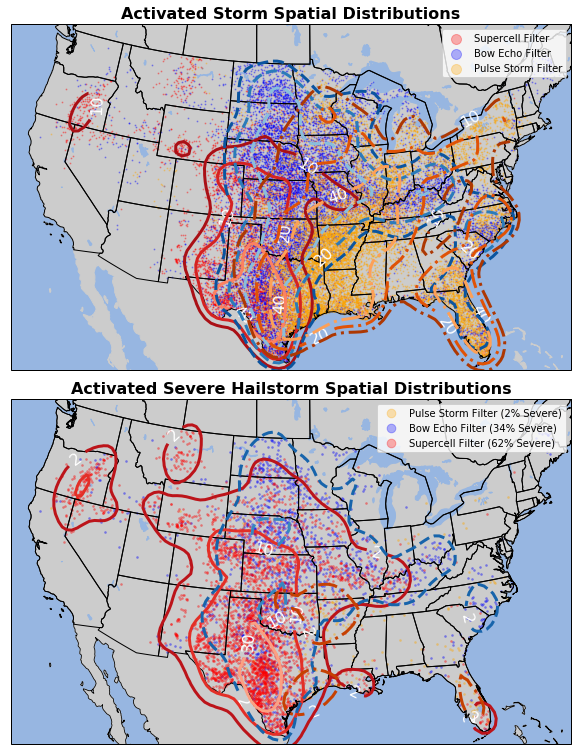

In [41]:
fig = plt.figure(figsize=(8, 10))
crs = ccrs.PlateCarree()
ax = fig.add_axes([0, 0.52, 1, 0.48], projection=ccrs.LambertConformal())
ax2 = fig.add_axes([0, 0, 1, 0.48], projection=ccrs.LambertConformal())
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor="0.8")
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS["water"])
states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', "50m",
                                          edgecolor="k", facecolor="none")
lakes_50m = cfeature.NaturalEarthFeature("physical", "lakes", "50m", edgecolor="face",
                                         facecolor=cfeature.COLORS["water"])
ax.add_feature(ocean_50m, zorder=1)
ax.add_feature(land_50m, zorder=2)
ax.add_feature(lakes_50m, zorder=2)
ax.add_feature(states_50m, zorder=3)
ax2.add_feature(ocean_50m, zorder=1)
ax2.add_feature(land_50m, zorder=2)
ax2.add_feature(lakes_50m, zorder=2)
ax2.add_feature(states_50m, zorder=3)
ax2.coastlines('50m', linewidth=0.8, zorder=4)
kde_contour_vals = np.array([0, 10, 20, 40])
kde_contour_vals_h = np.array([0, 2, 10, 30])
kde_contour_vals_h_2 =np.array([0, 2, 10])
ax.scatter(storm_meta.loc[idxs, "center_lon"], storm_meta.loc[idxs, "center_lat"], 1, "red", alpha=0.3, 
           transform=crs, zorder=3, label="Supercell Filter")
ax.scatter(storm_meta.loc[idxs_2, "center_lon"], storm_meta.loc[idxs_2, "center_lat"], 
           1, "blue", alpha=0.3, transform=crs, zorder=3, label="Bow Echo Filter")
ax.scatter(storm_meta.loc[idxs_3, "center_lon"], storm_meta.loc[idxs_3, "center_lat"], 
           1, "orange", alpha=0.3, transform=crs, zorder=3, label="Pulse Storm Filter")
s_cont_1 = ax.contour(lon_grid, lat_grid, out_1.reshape(lon_grid.shape), 
            kde_contour_vals, vmin=0, vmax=70, transform=crs, 
            zorder=6, linewidths=3, cmap="Reds_r", )
ax.clabel(s_cont_1, fmt="%1.0f", fontsize=16, colors="w")
s_cont_2 = ax.contour(lon_grid, lat_grid, out_2.reshape(lon_grid.shape), 
            kde_contour_vals, vmin=0, vmax=70, transform=crs, 
            zorder=6, linewidths=3, cmap="Blues_r", linestyles='--')
ax.clabel(s_cont_2, fmt="%1.0f", fontsize=16, colors="w")
s_cont_3 = ax.contour(lon_grid, lat_grid, out_3.reshape(lon_grid.shape), 
            kde_contour_vals, vmin=0, vmax=70, transform=crs, 
            zorder=6, linewidths=3, cmap="Oranges_r", linestyles='-.')
ax.clabel(s_cont_3, fmt="%1.0f", fontsize=16, colors="w")



ax2.scatter(storm_meta.loc[idxs_3_hail, "center_lon"], storm_meta.loc[idxs_3_hail, "center_lat"], 
           3, "orange", alpha=0.3, transform=crs, zorder=3, label="Pulse Storm Filter ({0:0.0f}% Severe)".format(storm_mode_hail_percent[2] * 100))
ax2.scatter(storm_meta.loc[idxs_2_hail, "center_lon"], storm_meta.loc[idxs_2_hail, "center_lat"], 
           3, "blue", alpha=0.3, transform=crs, zorder=3, label="Bow Echo Filter ({0:0.0f}% Severe)".format(storm_mode_hail_percent[1] * 100))
ax2.scatter(storm_meta.loc[idxs_hail, "center_lon"], storm_meta.loc[idxs_hail, "center_lat"], 3, "red", alpha=0.3, 
           transform=crs, zorder=3, label="Supercell Filter ({0:0.0f}% Severe)".format(storm_mode_hail_percent[0] * 100))
su_cont = ax2.contour(lon_grid, lat_grid, out_1_h.reshape(lon_grid.shape), 
            kde_contour_vals_h, vmin=-10, vmax=50, transform=crs, 
            zorder=6, linewidths=3, cmap="Reds_r", )
be_cont = ax2.contour(lon_grid, lat_grid, out_2_h.reshape(lon_grid.shape), 
            kde_contour_vals_h_2, vmin=-10, vmax=50, transform=crs, 
            zorder=6, linewidths=3, cmap="Blues_r", linestyles='--')

pu_cont = ax2.contour(lon_grid, lat_grid, out_3_h.reshape(lon_grid.shape), 
            kde_contour_vals_h_2, vmin=-10, vmax=50, transform=crs, 
            zorder=6, linewidths=3, cmap="Oranges_r", linestyles='-.')
ax2.clabel(su_cont, fmt="%1.0f", fontsize=16, colors='w')
ax2.clabel(be_cont, fmt="%1.0f", fontsize=16, colors='w')
ax2.clabel(pu_cont, fmt="%1.0f", fontsize=16, colors='w')

ax.set_extent((-120, -74, 23, 50))
ax2.set_extent((-120, -74, 23, 50))

ax.legend(loc=1, fontsize=10, markerscale=10)
ax2.legend(loc=1, fontsize=10, markerscale=5)
ax2.set_title("Activated Severe Hailstorm Spatial Distributions", fontsize=16, fontweight="bold")
ax.set_title("Activated Storm Spatial Distributions", fontsize=16, fontweight="bold")
plt.savefig("activation_spatial_dist_hail.png", bbox_inches="tight", dpi=300)

Plot the diurnal distribution of hailstorms for each neuron activation.

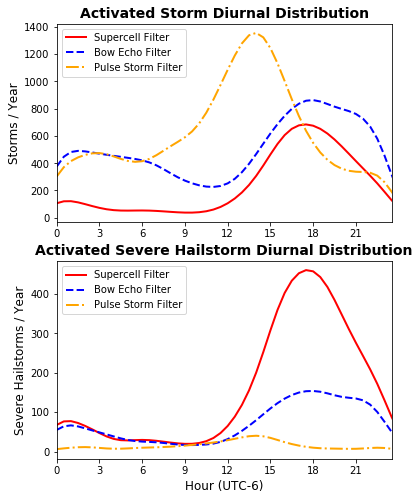

In [43]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(6, 8))
kd_time_0 = KernelDensity(bandwidth=1)
kd_time_0.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs, "valid_dates"]).hour - 6) % 24, axis=1))
kd_time_1 = KernelDensity(bandwidth=1)
kd_time_1.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs_2, "valid_dates"]).hour - 6) % 24, axis=1))
kd_time_2 = KernelDensity(bandwidth=1)
kd_time_2.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs_3, "valid_dates"]).hour - 6) % 24, axis=1))
kd_time_0_h = KernelDensity(bandwidth=1)
kd_time_0_h.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs_hail, "valid_dates"]).hour - 6) % 24, axis=1))
kd_time_1_h = KernelDensity(bandwidth=1)
kd_time_1_h.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs_2_hail, "valid_dates"]).hour - 6) % 24, axis=1))
kd_time_2_h = KernelDensity(bandwidth=1)
kd_time_2_h.fit(np.expand_dims((pd.DatetimeIndex(storm_meta.loc[idxs_3_hail, "valid_dates"]).hour - 6) % 24, axis=1))
times = np.arange(0, 24.5, 0.5)
ax_1.plot(times, np.exp(kd_time_0.score_samples(times.reshape(-1, 1))) * idxs.sum() / 10 / 32 * 365, color="red", linewidth=2, label="Supercell Filter")
ax_1.plot(times, np.exp(kd_time_1.score_samples(times.reshape(-1, 1))) * idxs_2.sum() / 10 / 32 * 365, color="blue", ls='--', linewidth=2, label="Bow Echo Filter")
ax_1.plot(times, np.exp(kd_time_2.score_samples(times.reshape(-1, 1))) * idxs_3.sum() / 10 / 32 * 365, color="orange", ls='-.', linewidth=2, label="Pulse Storm Filter")
ax_1.set_xticks(np.arange(0, 24, 3))
ax_1.set_xlim(0, 23.5)
ax_1.legend(loc=0)
#ax_1.set_xlabel("Hour (UTC-6)", fontsize=12)
ax_1.set_ylabel("Storms / Year", fontsize=12)
ax_1.set_title("Activated Storm Diurnal Distribution", fontsize=14, fontweight="bold")
ax_2.plot(times, np.exp(kd_time_0_h.score_samples(times.reshape(-1, 1))) * idxs_hail.sum() / 10 / 32 * 365, color="red", linewidth=2, label="Supercell Filter")
ax_2.plot(times, np.exp(kd_time_1_h.score_samples(times.reshape(-1, 1))) * idxs_2_hail.sum() / 10 / 32 * 365, color="blue", ls='--', linewidth=2, label="Bow Echo Filter")
ax_2.plot(times, np.exp(kd_time_2_h.score_samples(times.reshape(-1, 1))) * idxs_3_hail.sum() / 10 / 26 * 365, color="orange", ls='-.', linewidth=2, label="Pulse Storm Filter")
ax_2.set_xticks(np.arange(0, 24, 3))
ax_2.set_xlim(0, 23.5)
ax_2.legend(loc=0)
ax_2.set_xlabel("Hour (UTC-6)", fontsize=12)
ax_2.set_ylabel("Severe Hailstorms / Year", fontsize=12)
ax_2.set_title("Activated Severe Hailstorm Diurnal Distribution", fontsize=14, fontweight="bold")
plt.savefig("activation_hour_dist_kde.pdf", bbox_inches="tight")

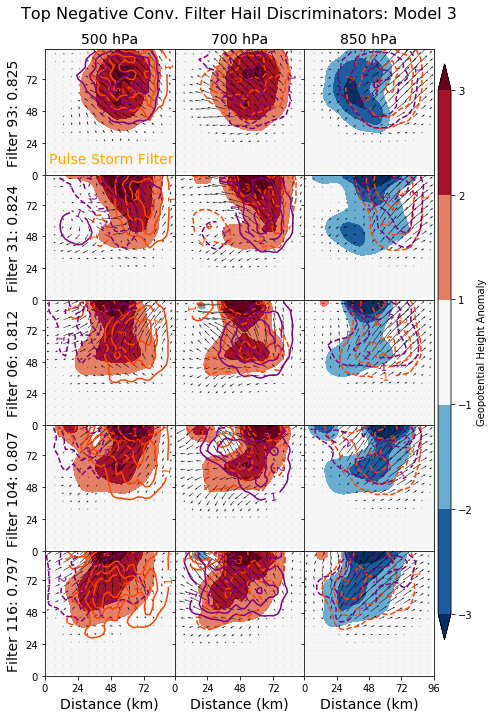

In [165]:
fig, axes = plt.subplots(5, 3, figsize=(6, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.05, 0.05, 0.95, 0.92, wspace=0, hspace=0)
contours = [-3, -2, -1, 1, 2, 3]
#ranked_weights = analog_info["Weights"].sort_values()[::-1].index
ranked_weights = analog_info["Negative_AUC"].argsort()[::-1].values
p_levels = [500, 700, 850]
for at in range(3):
    axes[0, at].set_title(f"{p_levels[at]:d} hPa", fontsize=14)
for (w,a), ax in np.ndenumerate(axes):
    weight = ranked_weights[w]
    height_g = gaussian_filter(-analog_gradients[weight, :, :, :, 0 + a].mean(axis=0), 1)
    height_g /= height_g.std()
    hght = ax.contourf(np.arange(0.5, 32), np.arange(0.5, 32), 
                 height_g, 
                contours, extend="both", cmap="RdBu_r")
    temp_g = gaussian_filter(-analog_gradients[weight, :, :, :, 3 + a].mean(axis=0), 1)
    temp_g /= temp_g.std()
    tc = ax.contour(np.arange(0.5, 32), np.arange(0.5, 32),
                    temp_g, contours, colors="orangered")
    ax.clabel(tc, fmt="%0.0f")
    dewp_g = gaussian_filter(-analog_gradients[weight, :, :, :, 6 + a].mean(axis=0), 1)
    dewp_g /= dewp_g.std()
    dc = ax.contour(dewp_g, contours, colors="purple")
    ax.clabel(dc, fmt="%0.0f")
    u_g = gaussian_filter(-analog_gradients[weight, :, :, :, 9 + a].mean(axis=0), 2)
    v_g = gaussian_filter(-analog_gradients[weight, :, :, :, 12 + a].mean(axis=0), 2)
    u_g /= u_g.std()
    v_g /= v_g.std()
    ax.quiver(np.arange(0.5, 32, 2), np.arange(0.5, 32, 2),
              u_g[::2, ::2], v_g[::2, ::2], scale=32)
    if a == 0 and w == 0:
        ax.text(1, 4, "Pulse Storm Filter", fontsize=14, color="Orange", ha="left", va="center")
    if a == 0:
        ax.set_ylabel("Filter {0:02d}: {1:0.3f}".format(ranked_weights[w], analog_info.loc[ranked_weights[w], "Negative_AUC"]),
                  fontsize=14)
    ax.set_yticks(np.arange(0, 36, 8))
    ax.set_yticklabels(np.arange(0, 36, 8) * 3)
    ax.set_xticks(np.arange(0, 36, 8))
    ax.set_xticklabels( np.arange(0, 36, 8) * 3)

    if w == 4:
        ax.set_xlabel("Distance (km)".format(p_levels[a]), fontsize=14)
    #ax.set_xlim(0, 16)
    #ax.set_ylim(16, 31)
cax = fig.add_axes([0.96, 0.1, 0.03, 0.8])
fig.colorbar(hght, cax=cax, label="Geopotential Height Anomaly")
plt.suptitle("Top Negative Conv. Filter Hail Discriminators: Model {0:d}".format(sample), fontsize=16)
plt.savefig("neg_auc_filter_gradients_{0:02d}.pdf".format(sample), dpi=300, bbox_inches="tight")

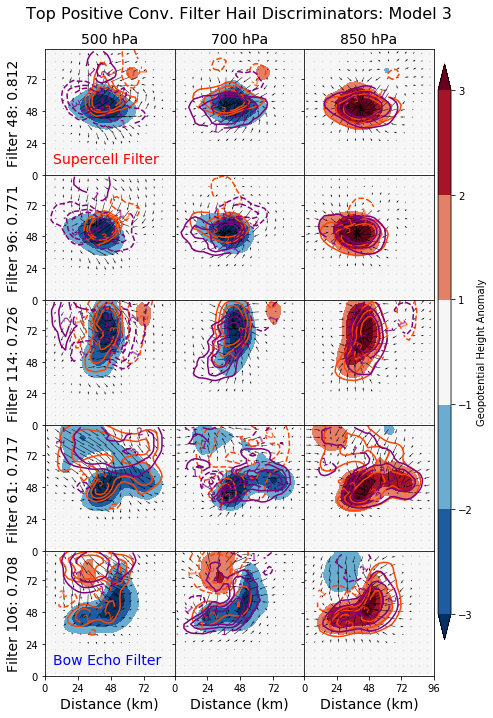

In [124]:
fig, axes = plt.subplots(5, 3, figsize=(6, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.05, 0.05, 0.95, 0.92, wspace=0, hspace=0)
contours = [-3, -2, -1, 1, 2, 3]
#ranked_weights = analog_info["Weights"].sort_values()[::-1].index
ranked_weights = analog_info["Positive_AUC"].argsort()[::-1].values
p_levels = [500, 700, 850]
for at in range(3):
    axes[0, at].set_title(f"{p_levels[at]:d} hPa", fontsize=14)
for (w,a), ax in np.ndenumerate(axes):
    weight = ranked_weights[w]
    height_g = gaussian_filter(-analog_gradients[weight, :, :, :, 0 + a].mean(axis=0), 1)
    height_g /= height_g.std()
    hght = ax.contourf(np.arange(0.5, 32), np.arange(0.5, 32), 
                 height_g, 
                contours, extend="both", cmap="RdBu_r")
    temp_g = gaussian_filter(-analog_gradients[weight, :, :, :, 3 + a].mean(axis=0), 1)
    temp_g /= temp_g.std()
    tc = ax.contour(np.arange(0.5, 32), np.arange(0.5, 32),
                    temp_g, contours, colors="orangered")
    ax.clabel(tc, fmt="%0.0f")
    dewp_g = gaussian_filter(-analog_gradients[weight, :, :, :, 6 + a].mean(axis=0), 1)
    dewp_g /= dewp_g.std()
    dc = ax.contour(dewp_g, contours, colors="purple")
    ax.clabel(dc, fmt="%0.0f")
    u_g = gaussian_filter(-analog_gradients[weight, :, :, :, 9 + a].mean(axis=0), 2)
    v_g = gaussian_filter(-analog_gradients[weight, :, :, :, 12 + a].mean(axis=0), 2)
    u_g /= u_g.std()
    v_g /= v_g.std()
    ax.quiver(np.arange(0.5, 32, 2), np.arange(0.5, 32, 2),
              u_g[::2, ::2], v_g[::2, ::2], scale=32)
    if a == 0 and w == 0:
        ax.text(2, 4, "Supercell Filter", fontsize=14, color="Red", ha="left", va="center")
    if a == 0 and w == 4:
        ax.text(2, 4, "Bow Echo Filter", fontsize=14, color="Blue", ha="left", va="center")
    if a == 0:
        ax.set_ylabel("Filter {0:02d}: {1:0.3f}".format(ranked_weights[w], analog_info.loc[ranked_weights[w], "Positive_AUC"]),
                  fontsize=14)
    ax.set_yticks(np.arange(0, 36, 8))
    ax.set_yticklabels(np.arange(0, 36, 8) * 3)
    ax.set_xticks(np.arange(0, 36, 8))
    ax.set_xticklabels( np.arange(0, 36, 8) * 3)

    if w == 4:
        ax.set_xlabel("Distance (km)".format(p_levels[a]), fontsize=14)
    #ax.set_xlim(0, 16)
    #ax.set_ylim(16, 31)
cax = fig.add_axes([0.96, 0.1, 0.03, 0.8])
fig.colorbar(hght, cax=cax, label="Geopotential Height Anomaly")
plt.suptitle("Top Positive Conv. Filter Hail Discriminators: Model {0:d}".format(sample), fontsize=16)
plt.savefig("top_auc_filter_gradients_{0:02d}.pdf".format(sample), dpi=300, bbox_inches="tight")

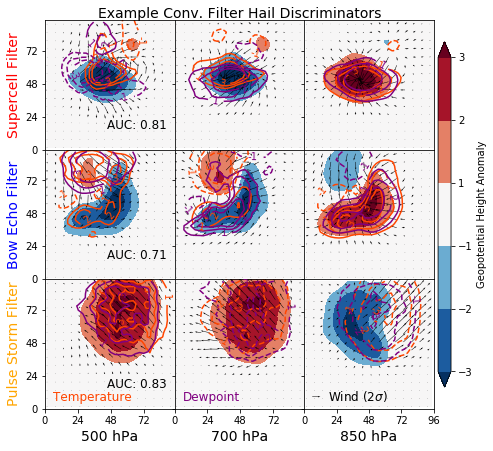

In [169]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6), sharex=True, sharey=True)
plt.subplots_adjust(0.05, 0.05, 0.95, 0.95, wspace=0, hspace=0)
contours = [-3, -2, -1, 1, 2, 3]
#ranked_weights = analog_info["Weights"].sort_values()[::-1].index
#ranked_weights = analog_info["Positive_AUC"].argsort()[::-1].values
ranked_weights = [48, 106, 93]
y_labels = ["Supercell Filter", "Bow Echo Filter", "Pulse Storm Filter"]
y_color = ["red", "blue", "orange"]
p_levels = [500, 700, 850]
for at in range(3):
    axes[-1, at].set_xlabel(f"{p_levels[at]:d} hPa", fontsize=14)
    axes[at, 0].set_ylabel(y_labels[at],color=y_color[at], fontsize=14)
for (w,a), ax in np.ndenumerate(axes):
    weight = ranked_weights[w]
    height_g = gaussian_filter(-analog_gradients[weight, :, :, :, 0 + a].mean(axis=0), 1)
    height_g /= height_g.std()
    hght = ax.contourf(np.arange(0.5, 32), np.arange(0.5, 32), 
                 height_g, 
                contours, extend="both", cmap="RdBu_r")
    temp_g = gaussian_filter(-analog_gradients[weight, :, :, :, 3 + a].mean(axis=0), 1)
    temp_g /= temp_g.std()
    tc = ax.contour(np.arange(0.5, 32), np.arange(0.5, 32),
                    temp_g, contours, colors="orangered")
    ax.clabel(tc, fmt="%0.0f")
    dewp_g = gaussian_filter(-analog_gradients[weight, :, :, :, 6 + a].mean(axis=0), 1)
    dewp_g /= dewp_g.std()
    dc = ax.contour(dewp_g, contours, colors="purple")
    ax.clabel(dc, fmt="%0.0f")
    u_g = gaussian_filter(-analog_gradients[weight, :, :, :, 9 + a].mean(axis=0), 2)
    v_g = gaussian_filter(-analog_gradients[weight, :, :, :, 12 + a].mean(axis=0), 2)
    u_g /= u_g.std()
    v_g /= v_g.std()
    qv = ax.quiver(np.arange(0.5, 32, 2), np.arange(0.5, 32, 2),
              u_g[::2, ::2], v_g[::2, ::2], scale=32)
    #if a == 0 and w == 0:
    #    ax.text(2, 4, "Supercell Filter", fontsize=14, color="Red", ha="left", va="center")
    #if a == 0 and w == 4:
    #    ax.text(2, 4, "Bow Echo Filter", fontsize=14, color="Blue", ha="left", va="center")
    #if a == 0:
    #    ax.set_ylabel("Filter {0:02d}: {1:0.3f}".format(ranked_weights[w], analog_info.loc[ranked_weights[w], "Positive_AUC"]),
    #              fontsize=14)
    ax.set_yticks(np.arange(0, 36, 8))
    ax.set_yticklabels(np.arange(0, 36, 8) * 3)
    ax.set_xticks(np.arange(0, 36, 8))
    ax.set_xticklabels( np.arange(0, 36, 8) * 3)

    if w == 4:
        ax.set_xlabel("Distance (km)".format(p_levels[a]), fontsize=14)
    #ax.set_xlim(0, 16)
    #ax.set_ylim(16, 31)
for i in range(3):
    max_auc = analog_info.loc[ranked_weights[i], ["Positive_AUC", "Negative_AUC"]].max()
    axes[i, 0].text(15,5, f"AUC: {max_auc:0.2f}", fontsize=12)
axes[-1, 0].text(2, 2, "Temperature", color="orangered", fontsize=12)
axes[-1, 1].text(2, 2, "Dewpoint", color="purple", fontsize=12)
axes[-1, 2].quiverkey(qv, 4, 3, 2, 'Wind (2$\sigma$)', coordinates='data', labelpos='E', fontproperties=dict(size=12))
cax = fig.add_axes([0.96, 0.1, 0.03, 0.8])
fig.colorbar(hght, cax=cax, label="Geopotential Height Anomaly")
plt.suptitle("Example Conv. Filter Hail Discriminators".format(sample), fontsize=14)
plt.savefig("rep_filter_gradients_{0:02d}.pdf".format(sample), dpi=300, bbox_inches="tight")

In [21]:
analog_info["Negative_AUC"].argsort()[::-1]

127     31
126    104
125      6
124     80
123     82
122     93
121     59
120    103
119     83
118     39
117    118
116    125
115    116
114    102
113     49
112     79
111     47
110     16
109     14
108     84
107      8
106     97
105     99
104    111
103      0
102     13
101     67
100    105
99      60
98      50
      ... 
29       5
28      15
27      76
26       3
25     126
24      27
23      37
22      52
21      73
20      87
19      88
18      72
17      65
16     114
15     124
14      20
13      86
12     115
11      98
10      30
9       57
8       56
7       62
6        7
5       53
4      106
3       61
2       96
1       64
0       48
Name: Negative_AUC, Length: 128, dtype: int64

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


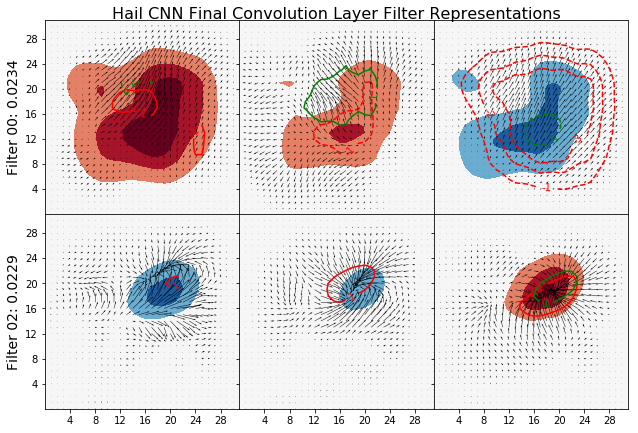

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
plt.subplots_adjust(0.05, 0.05, 0.95, 0.95, wspace=0, hspace=0)
contours = [-3, -2, -1, 1, 2, 3]
ranked_weights = analog_info["Weights"].sort_values()[::-1].index[[0,2]]
f_number = [0, 2]
p_levels = [500, 700, 850]
for (w,a), ax in np.ndenumerate(axes):
    weight = ranked_weights[w]
    ax.contourf(gaussian_filter(analog_gradients[weight, :, :, :, 0 + a].mean(axis=0), 1), contours, extend="both", cmap="RdBu_r")
    tc = ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 3 + a].mean(axis=0), 1), contours, colors="red")
    ax.clabel(tc, fmt="%0.0f")
    dc = ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 6 + a].mean(axis=0), 1), contours, colors="green")
    ax.clabel(dc, fmt="%0.0f")
    ax.quiver(gaussian_filter(analog_gradients[weight, :, :, :, 9 + a].mean(axis=0), 1),
             gaussian_filter(analog_gradients[weight, :, :, :, 12 + a].mean(axis=0), 1))
    if a == 0:
        ax.set_ylabel("Filter {0:02d}: {1:0.4f}".format(f_number[w], analog_info.loc[ranked_weights[w], "Weights"]),
                  fontsize=14)
    ax.set_yticks(np.arange(4, 32, 4))
    ax.set_xticks(np.arange(4, 32, 4))
    if w == 5:
        ax.set_xlabel("{0:d} mb".format(p_levels[a]), fontsize=14)
    #ax.set_xlim(0, 16)
    #ax.set_ylim(16, 31)
plt.suptitle("Hail CNN Final Convolution Layer Filter Representations", fontsize=16)
plt.savefig("top_filter_gradients_{0:02d}_reduced.pdf".format(sample), dpi=300, bbox_inches="tight")